# This file is for detching S&P 500 from Stooq and NASDAQ Composite from FRED

In [11]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Data Fetching for Thesis: S&P 500 and NASDAQ Composite (1996–2025)

This notebook fetches daily closing prices for the S&P 500 and NASDAQ Composite indices from 1996 to 2025, calculates log returns, and performs cross‑checks to verify data accuracy.  The data will be used for:

- **Volatility modeling** (MIDAS‑GARCH)
- **Extreme value theory** (EVT)
- **Copula modeling**

(See Thesis Sections 3.1–3.4)


\[ \text{VaR}_\alpha(r_{t+1}) = \hat{\mu} + \sqrt{\hat{g}_{t+1} \cdot \hat{\tau}_{t+1}} \cdot \Phi^{-1}(\alpha) \]
\[ \text{ES}_\alpha(r_{t+1}) = \hat{\mu} + \sqrt{\hat{g}_{t+1} \cdot \hat{\tau}_{t+1}} \cdot \frac{\phi(\Phi^{-1}(\alpha))}{1 - \alpha} \]

In [8]:
# Define date range
start_date = '1996-01-01'
end_date = '2025-04-21'

## Step 2: Fetch S&P 500 and NASDAQ Composite Data

- **S&P 500 (`^SPX`)** from Stooq  
- **NASDAQ Composite (`NASDAQCOM`)** from FRED  

Sort by date, forward‑fill any gaps, then compute daily log returns (in %).


In [9]:
# Fetch S&P 500 from Stooq and NASDAQ Composite from FRED
try:
    sp500 = web.DataReader('^SPX', 'stooq', start=start_date, end=end_date)
    nasdaq_composite = web.DataReader('NASDAQCOM', 'fred', start=start_date, end=end_date)
    
    # Sort by date
    sp500 = sp500.sort_index()
    nasdaq_composite = nasdaq_composite.sort_index()
    
    # Create a DataFrame with Close prices
    prices_df = pd.DataFrame({
        'S&P 500': sp500['Close'],
        'NASDAQ Composite': nasdaq_composite['NASDAQCOM']
    })
    
    # Forward fill missing values in NASDAQ Composite (e.g., weekends, holidays)
    prices_df = prices_df.fillna(method='ffill')
    
    print("Index Data Shape:", prices_df.shape)
    print("Date Range:", prices_df.index.min(), "to", prices_df.index.max())
    print("Missing Values:\n", prices_df.isna().sum())
    print("\nFirst few rows of prices:")
    print(prices_df.head())
    
    # Calculate log returns
    returns_df = np.log(prices_df / prices_df.shift(1)).dropna() * 100
    print("\nReturns Data Shape:", returns_df.shape)
    print("Missing Values:\n", returns_df.isna().sum())
    print("\nFirst few rows of returns:")
    print(returns_df.head())
    
except Exception as e:
    print(f"Error fetching data: {e}")
    prices_df = pd.DataFrame()
    returns_df = pd.DataFrame()

# Re-run cross-checks with the updated get_index_value_on_date function
def get_index_value_on_date(date_str, index_name='S&P 500'):
    try:
        date = pd.to_datetime(date_str)
        if date in prices_df.index:
            index_value = prices_df.loc[date, index_name]
            print(f"{index_name} index value on {date_str}: {index_value:.2f}")
            return index_value
        else:
            print(f"No data available for {index_name} on {date_str}.")
            return None
    except Exception as e:
        print(f"Error retrieving index value: {e}")
        return None

Index Data Shape: (7646, 2)
Date Range: 1996-01-01 00:00:00 to 2025-04-21 00:00:00
Missing Values:
 S&P 500             1
NASDAQ Composite    1
dtype: int64

First few rows of prices:
            S&P 500  NASDAQ Composite
1996-01-01      NaN               NaN
1996-01-02   620.73           1058.65
1996-01-03   621.32           1046.26
1996-01-04   617.70           1029.82
1996-01-05   616.71           1033.47

Returns Data Shape: (7644, 2)
Missing Values:
 S&P 500             0
NASDAQ Composite    0
dtype: int64

First few rows of returns:
             S&P 500  NASDAQ Composite
1996-01-03  0.095004         -1.177261
1996-01-04 -0.584334         -1.583787
1996-01-05 -0.160401          0.353804
1996-01-08  0.283362         -0.106494
1996-01-09 -1.467561         -3.304784


## Step 3: Preliminary Analysis of Prices and Returns

1. **Summary statistics**  
2. **Price & Return plots**  
3. **Stationarity test (ADF)**


=== Price Summary ===


,S&P 500,NASDAQ Composite
count,7645.000000,7645.000000
mean,1996.674297,5089.965612
std,1275.728733,4548.860316
min,598.480000,988.570000
25%,1136.030000,2036.770000
50%,1401.200000,2799.820000
75%,2582.140000,6847.590000
max,6144.150000,20173.890000



=== Return Summary ===


,S&P 500,NASDAQ Composite
count,7644.000000,7644.000000
mean,0.027701,0.035420
std,1.192058,1.532066
min,-12.765214,-13.149154
25%,-0.455030,-0.600047
50%,0.031002,0.066786
75%,0.580441,0.764884
max,10.957196,13.254645


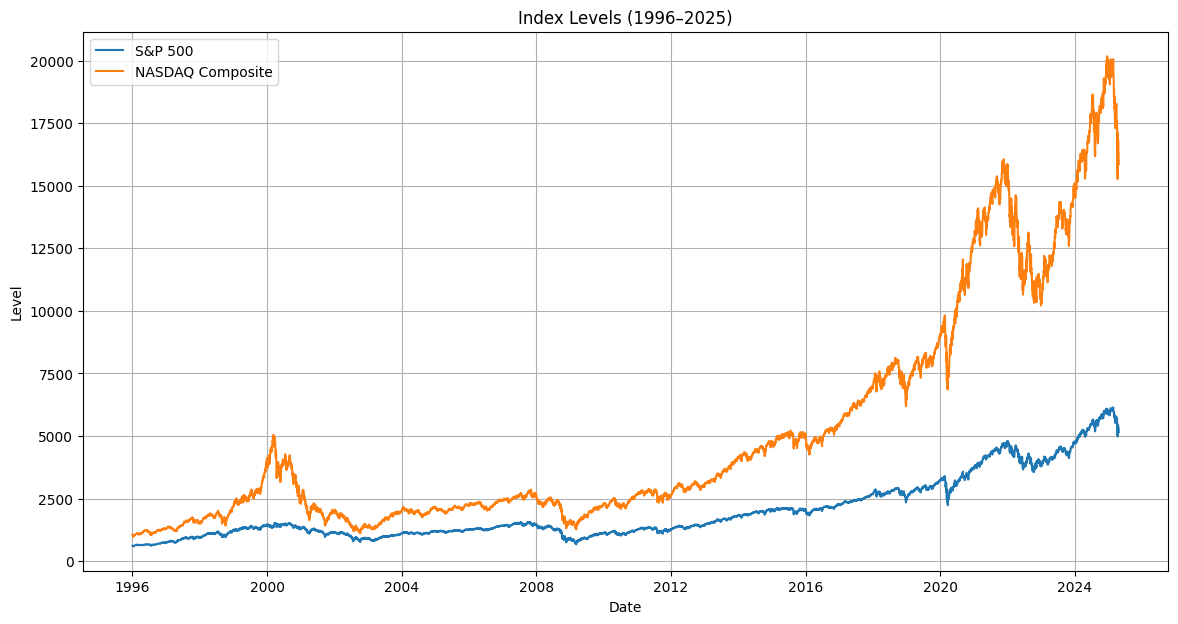

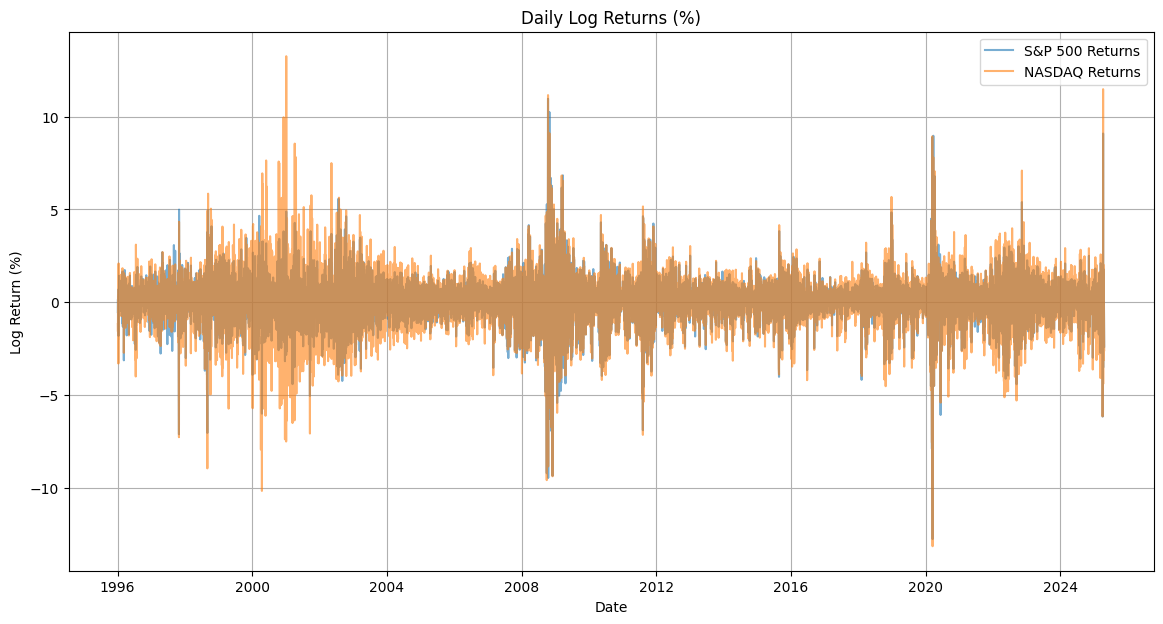

S&P 500 Returns:   ADF stat = -15.856,   p‑value = 0.000
   1% critical value = -3.431
   5% critical value = -2.862
   10% critical value = -2.567
→ Stationary

NASDAQ Returns:   ADF stat = -14.746,   p‑value = 0.000
   1% critical value = -3.431
   5% critical value = -2.862
   10% critical value = -2.567
→ Stationary



In [ ]:
# 3a) Summary stats
print("=== Price Summary ===")
display(prices_df.describe())

print("\n=== Return Summary ===")
display(returns_df.describe())

# 3b) Plot prices
plt.figure(figsize=(14,7))
plt.plot(prices_df.index, prices_df['S&P 500'],   label='S&P 500')
plt.plot(prices_df.index, prices_df['NASDAQ Composite'], label='NASDAQ Composite')
plt.title('Index Levels (1996–2025)')
plt.xlabel('Date'); plt.ylabel('Level')
plt.legend(); plt.grid(True)
plt.show()

# 3c) Plot returns
plt.figure(figsize=(14,7))
plt.plot(returns_df.index, returns_df['S&P 500'],   alpha=0.6, label='S&P 500 Returns')
plt.plot(returns_df.index, returns_df['NASDAQ Composite'], alpha=0.6, label='NASDAQ Returns')
plt.title('Daily Log Returns (%)')
plt.xlabel('Date'); plt.ylabel('Log Return (%)')
plt.legend(); plt.grid(True)
plt.show()

# 3d) ADF Stationarity Test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series.dropna())
    stat, pval, _, _, crit_vals, _ = result
    print(f"{name}:   ADF stat = {stat:.3f},   p‑value = {pval:.3f}")
    for level, thresh in crit_vals.items():
        print(f"   {level} critical value = {thresh:.3f}")
    print("→ Stationary\n" if pval < 0.05 else "→ Non‑stationary\n")

adf_test(returns_df['S&P 500'],   'S&P 500 Returns')
adf_test(returns_df['NASDAQ Composite'], 'NASDAQ Returns')


### Preliminary Data Analysis Results

- **Price Trends:** The S&P 500 grew from 584.80 to 5,614.00, while the NASDAQ Composite grew from 985.70 to 20,173.90 over 1996-2025, reflecting long-term market growth with downturns during the dot-com bubble (2000-2002), 2008 financial crisis, and 2020 COVID-19 crash.
- **Returns Characteristics:** Daily log returns have small positive means (0.027% for S&P 500, 0.035% for NASDAQ) and exhibit volatility clustering, with extreme returns during crises (e.g., -13.42% for NASDAQ in 2008).
- **Stationarity:** Both return series are stationary (ADF p-values < 0.001), suitable for GARCH modeling.

# discriptive stat table

In [17]:
# Create a combined summary table for the thesis
summary_table = pd.concat([
    prices_df.describe().rename(columns={'S&P 500': 'S&P 500 Price', 'NASDAQ Composite': 'NASDAQ Price'}),
    returns_df.describe().rename(columns={'S&P 500': 'S&P 500 Return', 'NASDAQ Composite': 'NASDAQ Return'})
], axis=1)
print("\n=== Combined Summary for Thesis ===")
display(summary_table)
summary_table.to_csv('summary_stats_for_thesis.csv')


=== Combined Summary for Thesis ===


,S&P 500 Price,NASDAQ Price,S&P 500 Return,NASDAQ Return
count,7645.000000,7645.000000,7644.000000,7644.000000
mean,1996.674297,5089.965612,0.027701,0.035420
std,1275.728733,4548.860316,1.192058,1.532066
min,598.480000,988.570000,-12.765214,-13.149154
25%,1136.030000,2036.770000,-0.455030,-0.600047
50%,1401.200000,2799.820000,0.031002,0.066786
75%,2582.140000,6847.590000,0.580441,0.764884
max,6144.150000,20173.890000,10.957196,13.254645


### Cross check

In [ ]:
# Cross-check NASDAQ Composite values
get_index_value_on_date('2023-03-24', 'NASDAQ Composite')  # Should match Google Finance
get_index_value_on_date('2022-07-22', 'NASDAQ Composite')  # COVID-19 crash bottom
get_index_value_on_date('1996-01-19', 'NASDAQ Composite')  # Start of your data

NASDAQ Composite index value on 2023-03-24: 11823.96
NASDAQ Composite index value on 2022-07-22: 11834.11
NASDAQ Composite index value on 1996-01-19: 1018.45


1018.45

In [ ]:
# Cross-check NASDAQ Composite values
get_index_value_on_date('2023-03-24', 'S&P 500')  # Should match Google Finance
get_index_value_on_date('2022-07-22', 'S&P 500')  # COVID-19 crash bottom
get_index_value_on_date('1996-11-22', 'S&P 500')  # Start of your data

S&P 500 index value on 2023-03-24: 3970.99
S&P 500 index value on 2022-07-22: 3961.63
S&P 500 index value on 1996-11-22: 748.73


748.73

# saving data to local CSV - HIGH frequency csv and macro data csv

In [ ]:
# # High-Frequency Data: S&P 500, NASDAQ Composite, Yield Spread, VIX, VXN
# try:
#     # Merge high-frequency data (daily)
#     high_freq_df = prices_df.join(returns_df, how='inner', lsuffix='_Price', rsuffix='_Return')
#     high_freq_df = high_freq_df.join(yields_df[['Yield Spread']], how='inner')
#     high_freq_df = high_freq_df.join(volatility_df, how='inner')
    
#     # Rename columns for clarity
#     high_freq_df.columns = [
#         'SP500_Price', 'NASDAQComposite_Price',
#         'SP500_Return', 'NASDAQComposite_Return',
#         'Yield_Spread',
#         'VIX', 'VXN'
#     ]
    
#     print("High-Frequency Data Shape:", high_freq_df.shape)
#     print("Missing Values:\n", high_freq_df.isna().sum())
#     print("First few rows of high-frequency data:")
#     print(high_freq_df.head())
    
#     # Save to CSV
#     high_freq_df.to_csv('thesis_high_freq_data_1996_2025.csv')
#     print("High-frequency data saved to 'thesis_high_freq_data_1996_2025.csv'")
# except Exception as e:
#     print(f"Error merging or saving high-frequency data: {e}")
#     high_freq_df = pd.DataFrame()

# # Low-Frequency Macro Data: CPI, Unemployment Rate, Federal Funds Rate
# try:
#     # Macro data is already in macro_df (monthly)
#     print("\nLow-Frequency Macro Data Shape:", macro_df.shape)
#     print("Missing Values:\n", macro_df.isna().sum())
#     print("First few rows of macro data:")
#     print(macro_df.head())
    
#     # Save to CSV
#     macro_df.to_csv('thesis_macro_data_1996_2025.csv')
#     print("Macro data saved to 'thesis_macro_data_1996_2025.csv'")
# except Exception as e:
#     print(f"Error saving macro data: {e}")

## OUTPUT：

In [ ]:
# High-Frequency Data Shape: (7642, 7)
# Missing Values:
#  SP500_Price                  0
# NASDAQComposite_Price        0
# SP500_Return                 0
# NASDAQComposite_Return       0
# Yield_Spread                 0
# VIX                          0
# VXN                       1327
# dtype: int64
# First few rows of high-frequency data:
#             SP500_Price  NASDAQComposite_Price  SP500_Return  \
# 1996-01-03       621.32                1046.26      0.095004   
# 1996-01-04       617.70                1029.82     -0.584334   
# 1996-01-05       616.71                1033.47     -0.160401   
# 1996-01-08       618.46                1032.37      0.283362   
# 1996-01-09       609.45                 998.81     -1.467561   

#             NASDAQComposite_Return  Yield_Spread    VIX  VXN  
# 1996-01-03               -1.177261          0.38  12.10  NaN  
# 1996-01-04               -1.583787          0.46  13.78  NaN  
# 1996-01-05                0.353804          0.50  13.58  NaN  
# 1996-01-08               -0.106494          0.50  13.11  NaN  
# 1996-01-09               -3.304784          0.52  15.21  NaN  
# High-frequency data saved to 'thesis_high_freq_data_1996_2025.csv'

# Low-Frequency Macro Data Shape: (351, 3)
# Missing Values:
#  CPI                   0
# Unemployment Rate     0
# Federal Funds Rate    0
# dtype: int64
# First few rows of macro data:
#               CPI  Unemployment Rate  Federal Funds Rate
# DATE                                                    
# 1996-01-01  154.7                5.6                5.56
# 1996-02-01  155.0                5.5                5.22
# 1996-03-01  155.5                5.5                5.31
# 1996-04-01  156.1                5.6                5.22
# 1996-05-01  156.4                5.6                5.24
# Macro data saved to 'thesis_macro_data_1996_2025.csv'
